# Examples using `MicroGridEnv`

This notebook explores the usage of `MicroGridEnv` through different strategies:
1. random action policy
2. market-only policy
3. battery-first policy
4. 20/80 policy
5. 50/50 policy
6. training a PPO agent with StableBaselines3 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/ernesto-gym


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from gymnasium.utils.env_checker import check_env

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.5)

In [14]:
def plot_rewards(rewards: list, timestamps: list, sampling_rate=50):
    nrows = 4
    ncols = 1
    labels = ['Trading', 'Operational Cost', 'Degradation', 'Action_clipping']

    fig, ax = plt.subplots(nrows, ncols, figsize=(12, 3*nrows), tight_layout=True, sharex=True)
    
    for j in range(nrows):
        ax[j].plot(timestamps[::sampling_rate], np.array(rewards)[:, j][::sampling_rate], label='{} Reward'.format(labels[j]), color=plot_colors[j])
        ax[j].set(xlabel='Time', ylabel='{} Reward'.format(labels[j]), 
                  xticks=[timestamps[0], timestamps[len(timestamps)//2],timestamps[-1]])
        #ax[j].legend()
        

def plot_cum_reward(env:MicroGridEnv, sampling_rate=50):
    timestamps = env.demand.timestamps

    fig, ax = plt.subplots(figsize=(12, 3.5), tight_layout=True)
    ax.plot(timestamps[::sampling_rate], np.cumsum([sum(r) for r in env.weighted_reward_list])[::sampling_rate], color=plot_colors[0])
    ax.set(xlabel='Time', ylabel='Cumulative Reward', 
           xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])


def plot_pure_rewards(env: MicroGridEnv):
    plot_rewards(env.pure_reward_list, env.demand.timestamps)


def plot_weighted_rewards(env: MicroGridEnv):
    plot_rewards(env.weighted_reward_list, env.demand.timestamps)

## Environment Information

In [4]:
pack_options = "ernestogym/ernesto/data/battery/pack.yaml"
# ecm = "ernestogym/ernesto/data/battery/models/electrical/thevenin_pack.yaml"
ecm = "ernestogym/ernesto/data/battery/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto/data/battery/models/thermal/r2c_thermal_pack.yaml"
bolun = "ernestogym/ernesto/data/battery/models/aging/bolun_pack.yaml"
# world = "ernestogym/envs/single_agent/world_deg.yaml"
world = "ernestogym/envs/single_agent/world_fading.yaml"

params = parameter_generator(
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True
)

In [5]:
# Create environment
env = MicroGridEnv(settings=params)

print('Size of State Space: ', env.observation_space.shape)
print('Observation Space: ', env.spaces.keys())
print('Size of Action Space: ', env.action_space.shape)
print('Min action: ', env.action_space.low)
print('Max action: ', env.action_space.high)
print('Sample State: ', env.observation_space.sample())
print('Sample Action: ', env.action_space.sample())

Size of State Space:  (10,)
Observation Space:  odict_keys(['temperature', 'soc', 'demand', 'generation', 'ask', 'bid', 'sin_day_of_year', 'cos_day_of_year', 'sin_seconds_of_day', 'cos_seconds_of_day'])
Size of Action Space:  (1,)
Min action:  [0.]
Max action:  [1.]
Sample State:  [ 3.8561795e+02  7.1710104e-01  1.0694071e-02  1.2048728e+00
  2.8072150e+00  8.4950075e-02 -9.4059730e-01  7.4145722e-01
  3.5420981e-01  2.7288276e-01]
Sample Action:  [0.19884102]


## Experiment settings

In [6]:
num_steps = len(env.demand)
num_steps = 100000

comparison_dict = {
    'actual_reward': {},
    'weighted_reward': {},
    'total_reward': {}
}

## Random action policy

In [7]:
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = env.action_space.sample()  # Randomly select an action
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


100%|██████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4089.82it/s]


In [9]:
comparison_dict['total_reward']['random_policy'] = env.total_reward
comparison_dict['actual_reward']['random_policy'] = env.pure_reward_list
comparison_dict['weighted_reward']['random_policy'] = env.weighted_reward_list

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

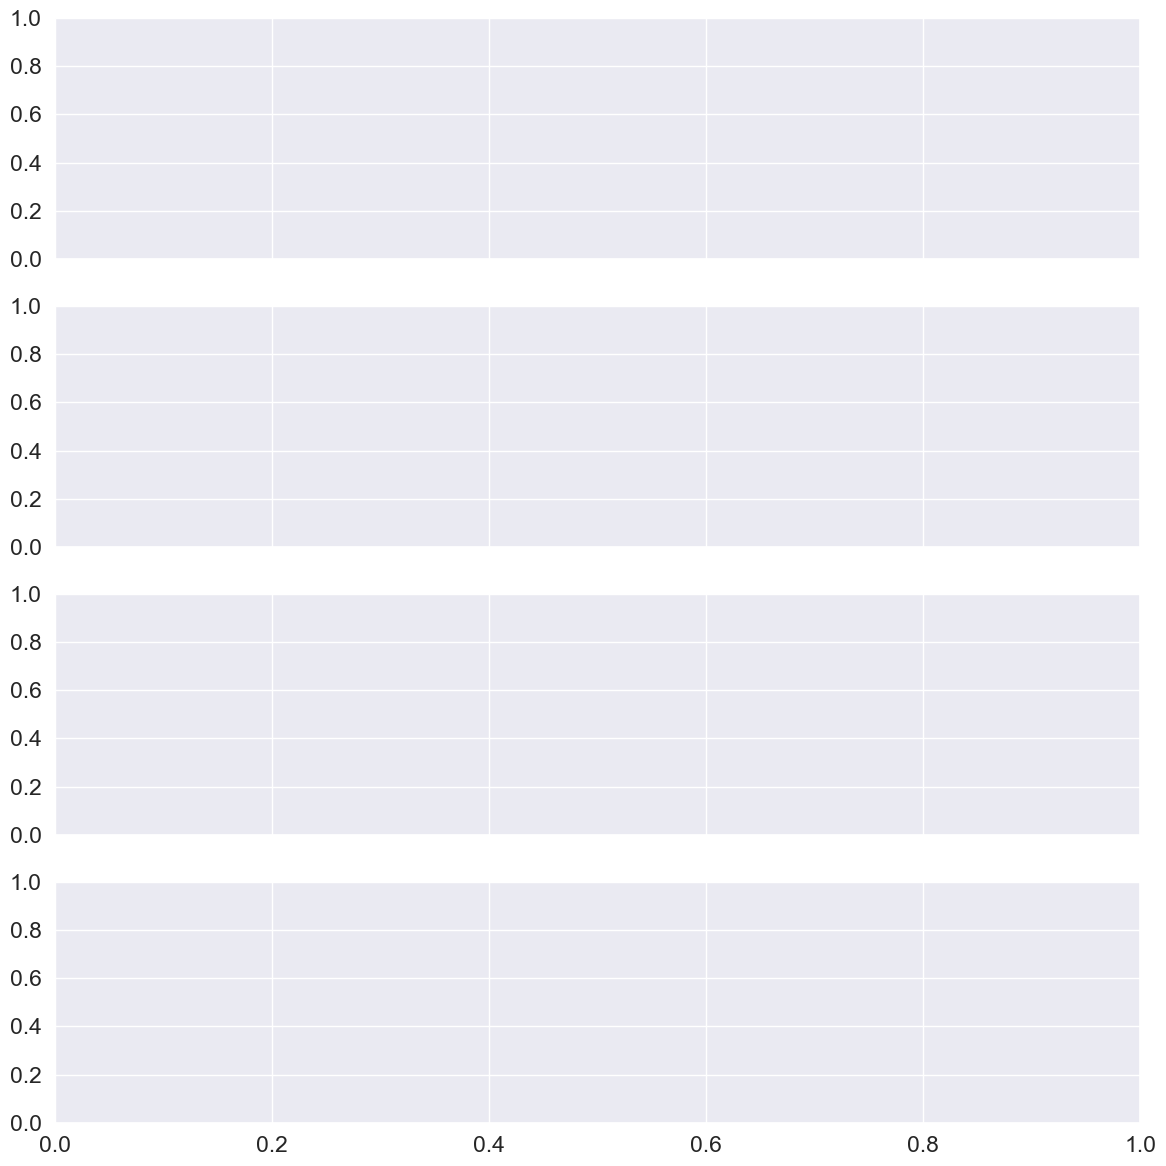

In [15]:
plot_pure_rewards(env)

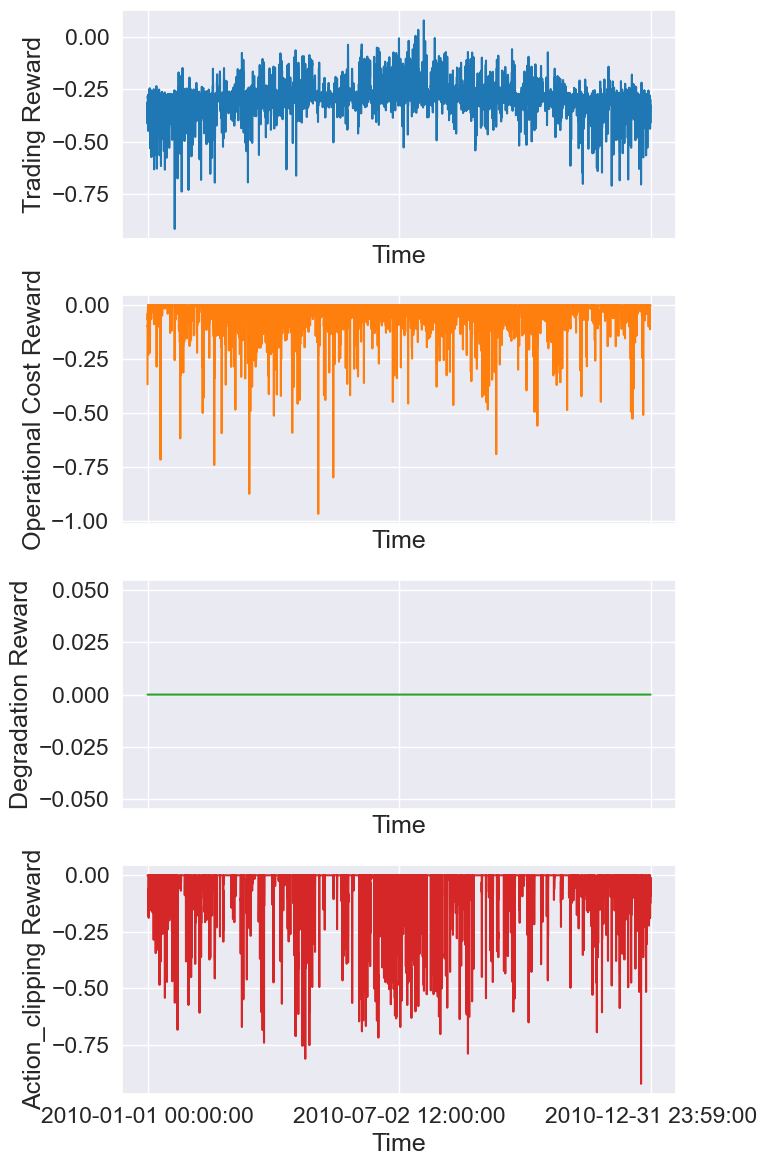

In [22]:
plot_weighted_rewards(env)

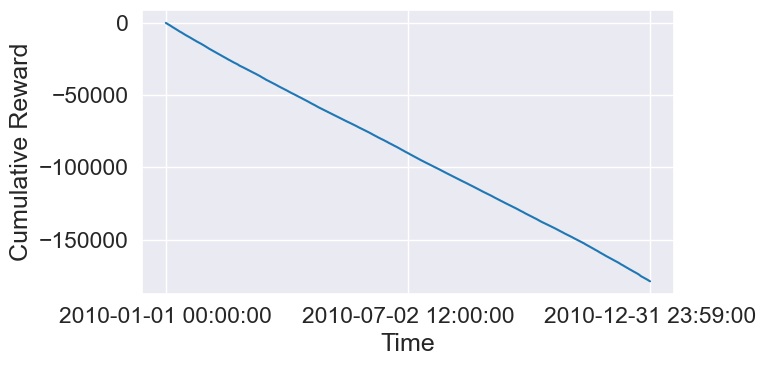

In [23]:
plot_cum_reward(env)

## Market-only policy

In [24]:
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = [0.]  # Only market
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


  0%|                                                                                                                                                                                                                                                                                     | 0/525600 [00:00<?, ?it/s]/Users/dave/miniconda3/envs/ernesto-gym/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525600/525600 [02:59<00:00, 2931.57it/s]


In [25]:
comparison_dict['total_reward']['market_only'] = env.total_reward
comparison_dict['actual_reward']['market_only'] = env.actual_reward_list
comparison_dict['weighted_reward']['market_only'] = env.weighted_reward_list

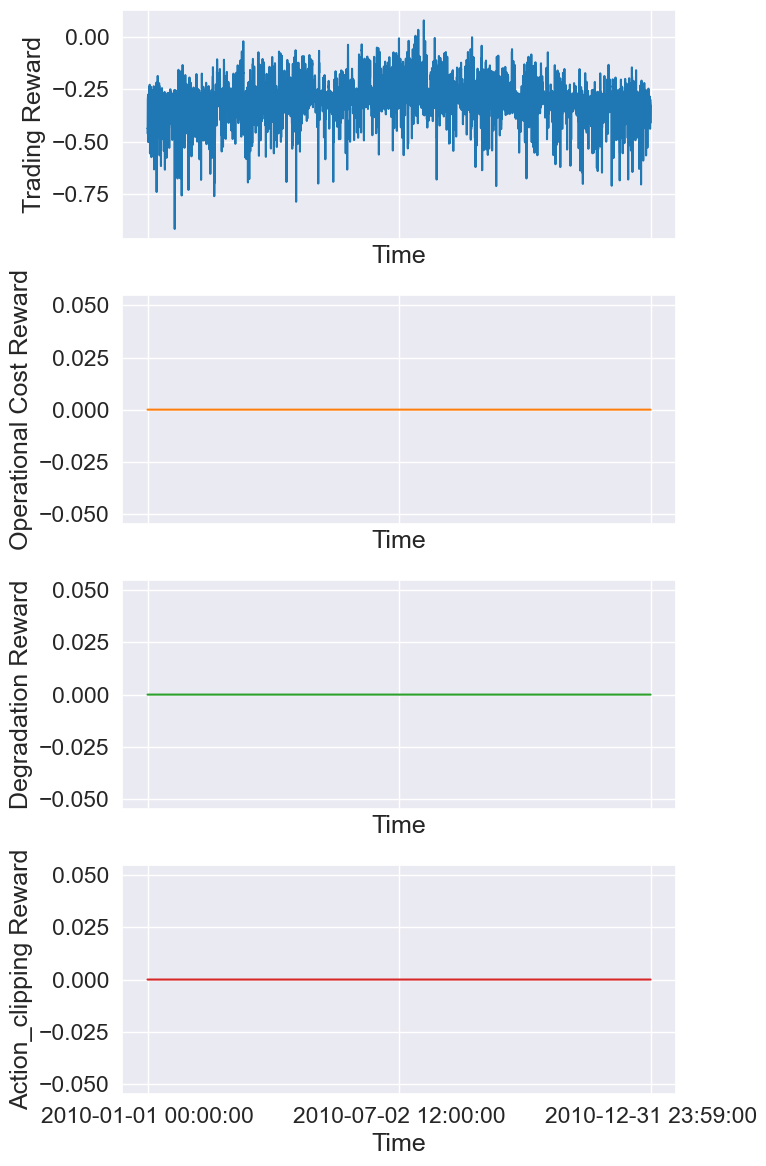

In [26]:
plot_actual_rewards(env)

## Battery-first policy

In [15]:
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = [1.]  # Battery first
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40320/40320 [00:15<00:00, 2616.41it/s]


In [16]:
comparison_dict['total_reward']['battery_first'] = env.total_reward
comparison_dict['actual_reward']['battery_first'] = env.actual_reward_list
comparison_dict['weighted_reward']['battery_first'] = env.weighted_reward_list

## 20-80 policy

In [17]:
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = [0.2]  # 20% to the battery
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40320/40320 [00:14<00:00, 2809.18it/s]


In [18]:
comparison_dict['total_reward']['20_80_policy'] = env.total_reward
comparison_dict['actual_reward']['20_80_policy'] = env.actual_reward_list
comparison_dict['weighted_reward']['20_80_policy'] = env.weighted_reward_list

## 50-50 policy

In [19]:
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = [0.5]  # 50% to the battery
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40320/40320 [00:14<00:00, 2862.75it/s]


In [20]:
comparison_dict['total_reward']['50_50_policy'] = env.total_reward
comparison_dict['actual_reward']['50_50_policy'] = env.actual_reward_list
comparison_dict['weighted_reward']['50_50_policy'] = env.weighted_reward_list

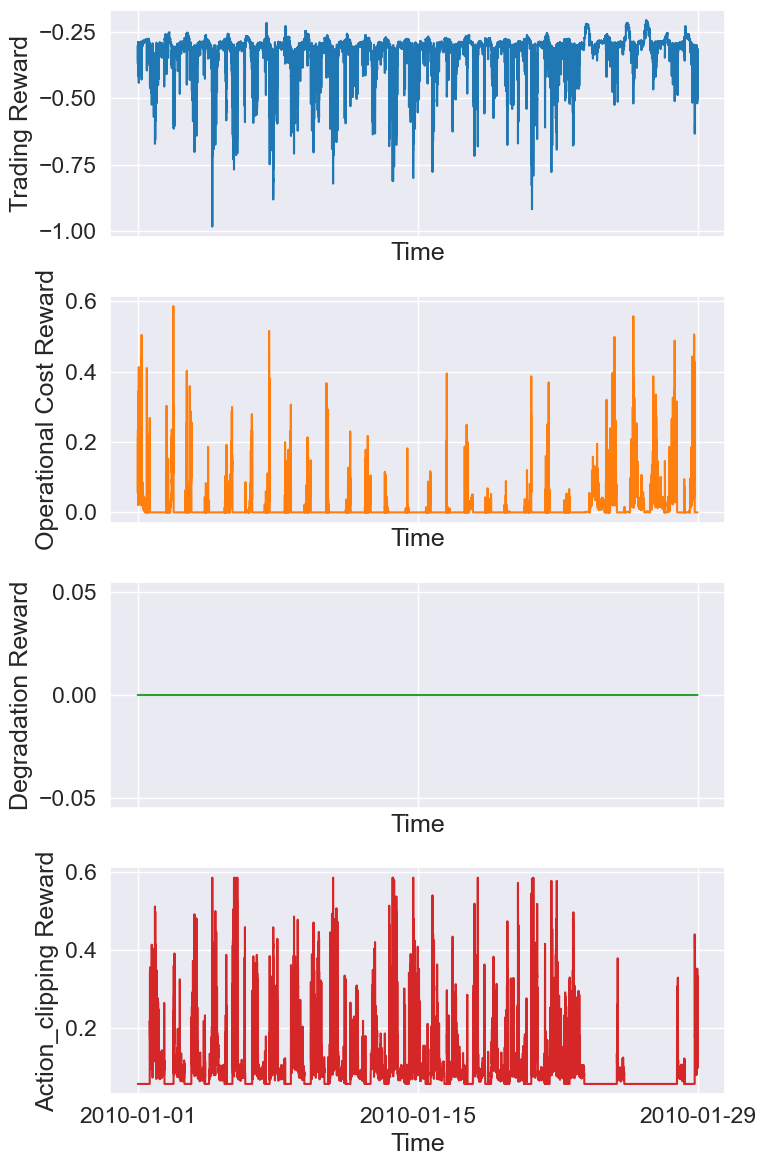

In [28]:
plot_actual_rewards(env)

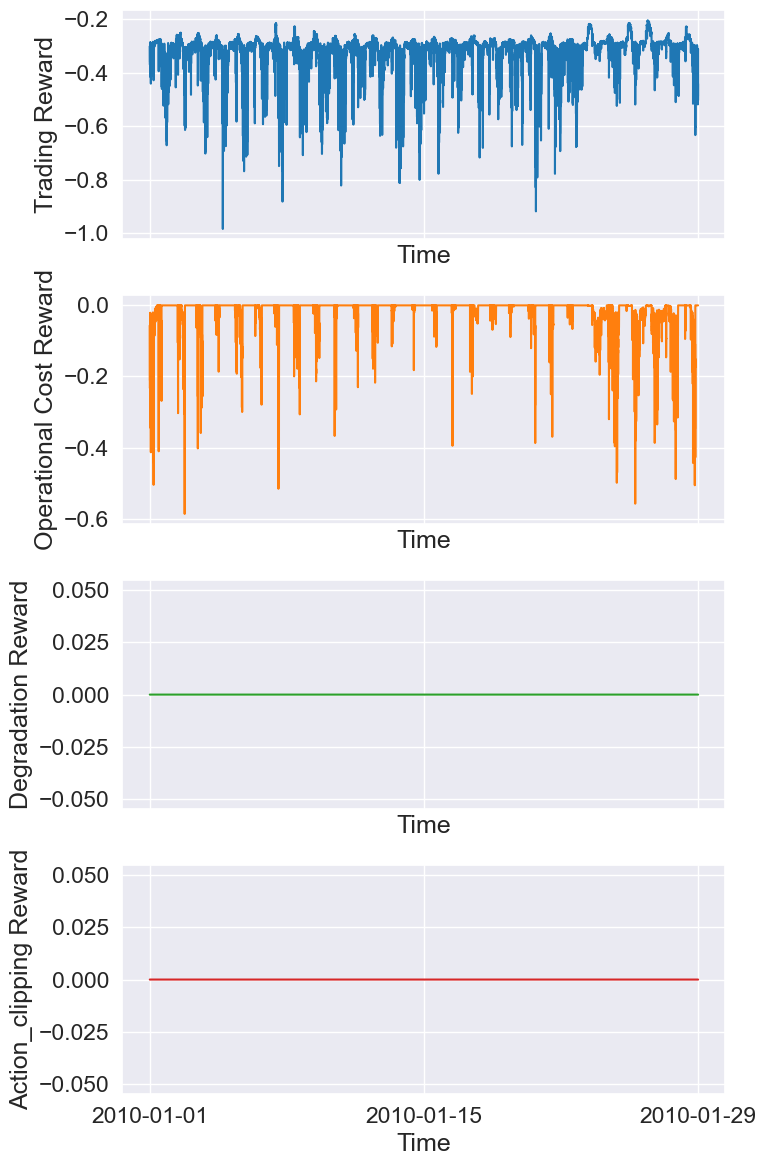

In [29]:
plot_weighted_rewards(env)

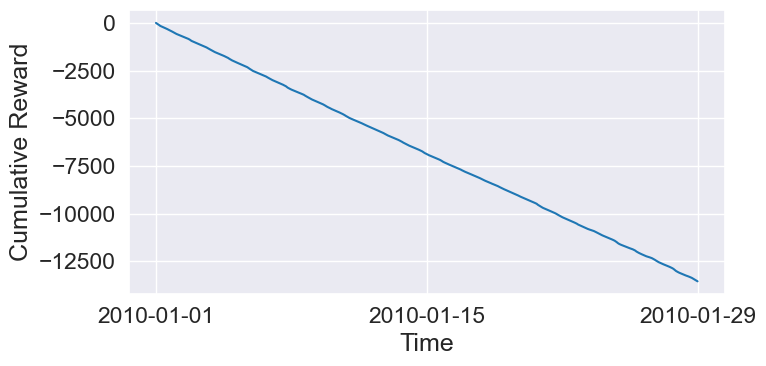

In [30]:
plot_cum_reward(env)

## PPO Agent

In [34]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

In [47]:
#model = PPO(MlpPolicy, env, verbose=0, batch_size=64)

#model.learn(total_timesteps=50*num_steps, progress_bar=True, log_interval=10000)
#print("################TRAINING is Done############")
 
model = PPO.load("logs/ppo/models/ppo_5200000_steps.zip", env=env)
    
actions = [] 
vec_env = model.get_env()
vec_env.set_options({'eval_profile': '67'})
obs = vec_env.reset()
for i in tqdm(range(num_steps)):
    action, _states = model.predict(obs)
    actions.append(action)
    obs, rewards, dones, info = vec_env.step(action)

profile:  67


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525600/525600 [04:56<00:00, 1771.68it/s]


In [48]:
actions

[array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([

In [39]:
comparison_dict['total_reward']['ppo'] = env.total_reward
comparison_dict['actual_reward']['ppo'] = env.actual_reward_list
comparison_dict['weighted_reward']['ppo'] = env.weighted_reward_list

## Comparison between the different baselines

In [44]:
timestamps = env.demand.timestamps

def cum_reward_comparison():
    fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)

    for i, item in enumerate(comparison_dict['weighted_reward'].items()):
        key, values = item
        ax.plot(timestamps, np.cumsum([sum(r) for r in values]), label=key, color=plot_colors[i])
        ax.set(xlabel='Time', ylabel='Cumulative Reward', 
                  xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])
    ax.legend()

def cum_reward_terms_comparison():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9), tight_layout=True, sharex=True)

    for i, item in enumerate(comparison_dict['actual_reward'].items()):
        key, values = item
        
        ax1.plot(timestamps, np.cumsum([r[0] for r in values]), label=key, color=plot_colors[i])
        ax1.set(xlabel='Time', ylabel='Cumulative Trading Reward', 
                xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])
          
        ax2.plot(timestamps, np.cumsum([r[1] for r in values]), label=key, color=plot_colors[i])
        ax2.set(xlabel='Time', ylabel='Cumulative Operational Cost', 
                xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])
          
        ax3.plot(timestamps, np.cumsum([r[2] for r in values]), label=key, color=plot_colors[i])
        ax3.set(xlabel='Time', ylabel='Cumulative Degradation Penalty', 
                xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])
          
        ax4.plot(timestamps, np.cumsum([r[3] for r in values]), label=key, color=plot_colors[i])
        ax4.set(xlabel='Time', ylabel='Cumulative Clipping Penalty', 
                xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])
    
    plt.legend(loc='upper center', bbox_to_anchor=(0, -0.3),ncol=5)

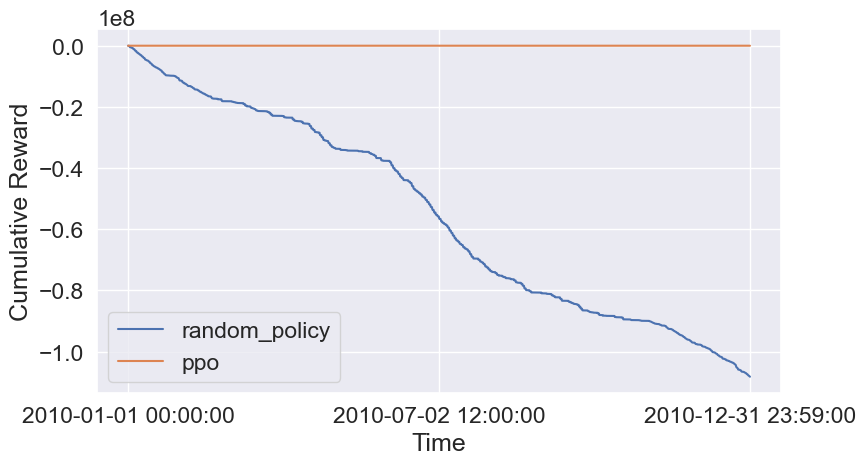

In [45]:
cum_reward_comparison()

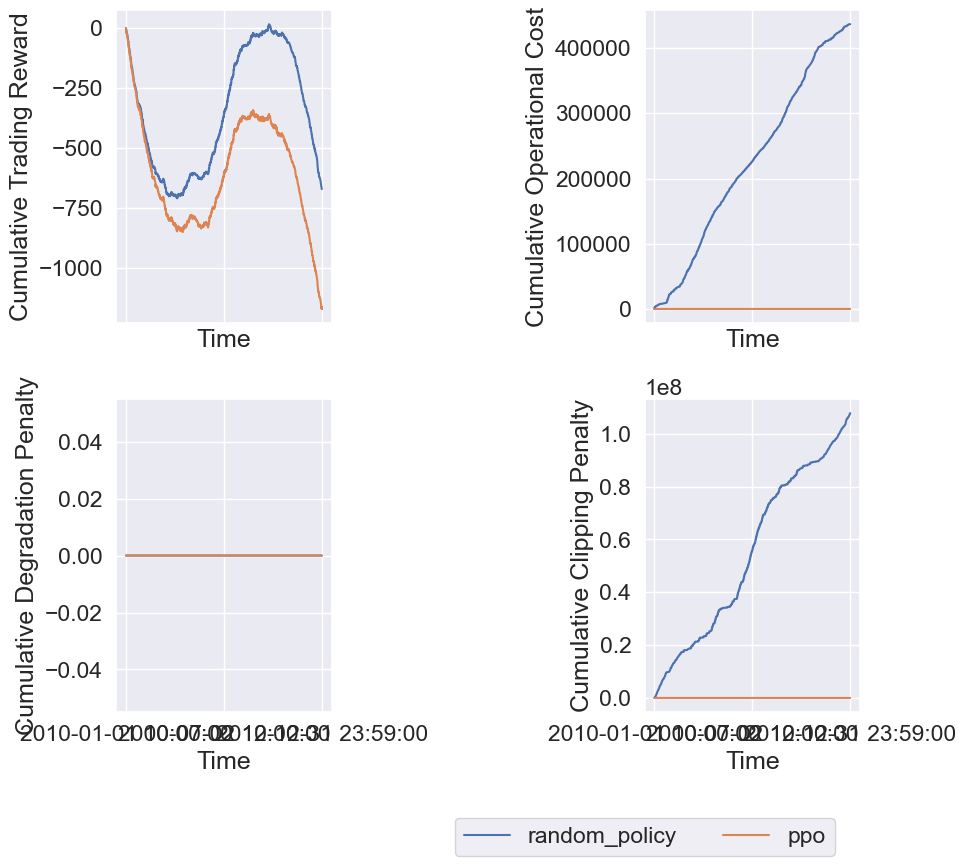

In [46]:
cum_reward_terms_comparison()